# How to characterize a Solar-like star with Lightkurve's asteroseismology tools?

The object *KIC 10963064* is a bright, solar-like, main sequence star that was observed by the Kepler spacecraft between 2009 and 2013.  This tutorial will use the data from this star to demonstrate Lightkurve's asteroseismology tools.

The steps demonstrated in this tutorial are:

1. Searching for the data
2. Downloading and correcting the data
3. Stitching the data together into a single lightcurve
4. Creating a bespoke periodogram
5. Manipulating and plotting a periodogram
6. Calculating a rudimentary numax and deltanu
7. Plotting an echelle diagram
8. Calculating a rudimentary asteroseismic mass, radius and surface gravity

In [1]:
import lightkurve as lk

In [2]:
datalist = lk.search_lightcurvefile('KIC10963065', cadence='short')
print(datalist)

SearchResult containing 29 data products.

 target_name                      productFilename                                 description              distance
------------- ------------------------------------------------------- ------------------------------------ --------
kplr010963065                    kplr010963065-2009259162342_slc.fits  Lightcurve Short Cadence (CSC) - Q2      0.0
kplr010963065                    kplr010963065-2010111051353_slc.fits  Lightcurve Short Cadence (CSC) - Q5      0.0
kplr010963065                    kplr010963065-2010140023957_slc.fits  Lightcurve Short Cadence (CSC) - Q5      0.0
kplr010963065                    kplr010963065-2010174090439_slc.fits  Lightcurve Short Cadence (CSC) - Q5      0.0
kplr010963065                    kplr010963065-2010203174610_slc.fits  Lightcurve Short Cadence (CSC) - Q6      0.0
kplr010963065                    kplr010963065-2010234115140_slc.fits  Lightcurve Short Cadence (CSC) - Q6      0.0
kplr010963065                

It looks like we've got plenty of quarters of data here. Let's download a couple of these back-to-back quarters. Lets do 5 through 7.

In [3]:
data = datalist[1:10].download_all()
data

LightCurveFileCollection of 9 objects:
	KIC 10963065 (9 KeplerLightCurveFiles) Quarters: 5,5,5,6,6,6,7,7,7

The data is now a `lightCurveFileCollection`, containing a bunch of different lightcurves. We can stitch these together to form a single lightcurve as follows:

In [4]:
lc = data.stitch()

Where the `.stitch()` method has taken the PDCSAP flux and appended them on to one another.

Now let's check out our timeseries!

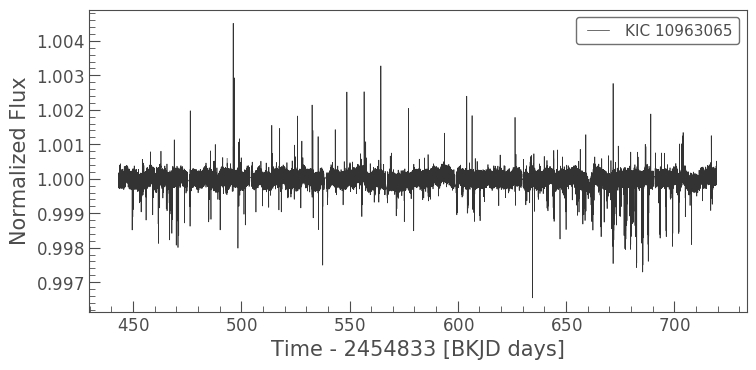

In [5]:
lc.plot()

That looks a bit messy--- let's do some tidying on this before we continue by removning any NaN values and trimming outliers. We're *not* going to flatten it using lightkurve's `flatten()` tool, because this can mess with the granulation background.

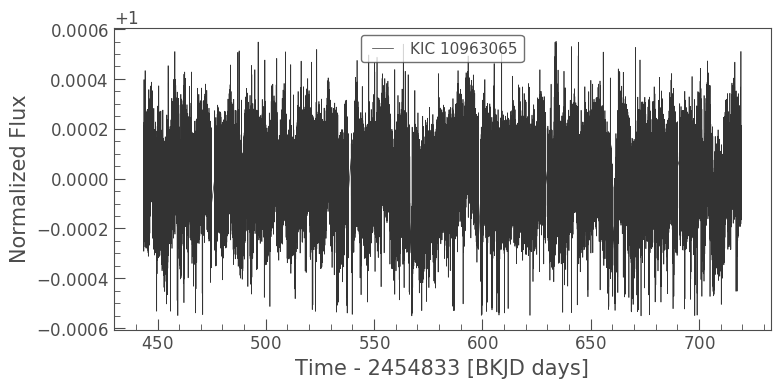

In [6]:
lc = lc.normalize().remove_outliers().remove_nans()
lc.plot()

Neat, we've got some data! Now let's try and do some asteroseismology with it.

We'll convert this data to a Lomb Scargle Periodogram. Because I'm a solar-like oscillators kind of asteroseismologist, I'm going to go ahead and set the normalization to 'psd'. This just means that the frequency units will be in $\mu Hz$, which I prefer, and that the power units will be in power density instead of amplitude. Give `normalization = 'amplitude'` a try too!

In [7]:
pg = lc.to_periodogram(method='lombscargle', normalization='psd')

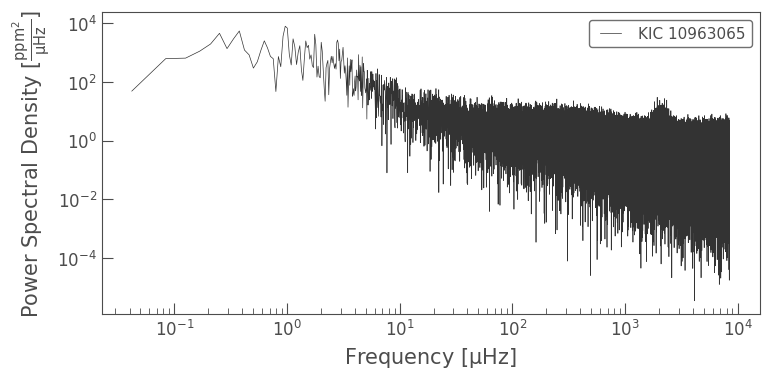

In [8]:
pg.plot(scale='log')

Looks like a power spectrum to me! There is a power excess around the $2000\, \mu \rm Hz$ mark, so lets get a closer look at that area. For this, I'll use the `minimum_frequency` and `maximum_frequency` keyword arguments. This truncates the frequency range evaluated when performing the LombScargle transformation.

For those of you who prefer to work in period instead of frequency, the `to_periodogram()` function has equivalent options to set `maximum_period` and `minimum_period`, or even pass in a custom grid of periods at which to compute the periodogram!

In [9]:
pg = lc.to_periodogram(method='lombscargle', normalization='psd',
                      minimum_frequency=1000, maximum_frequency=3000)

To get a nicer look at the data, we'll also plot a smoothed periodogram over the top. The `periodogram().smooth()` option stacks like most other `lightkurve` functions, making this an easy operation to do. The `ax` keyword argument in `lightkurve`'s `plot` function makes plotting multiple objects on the same graph easy too!

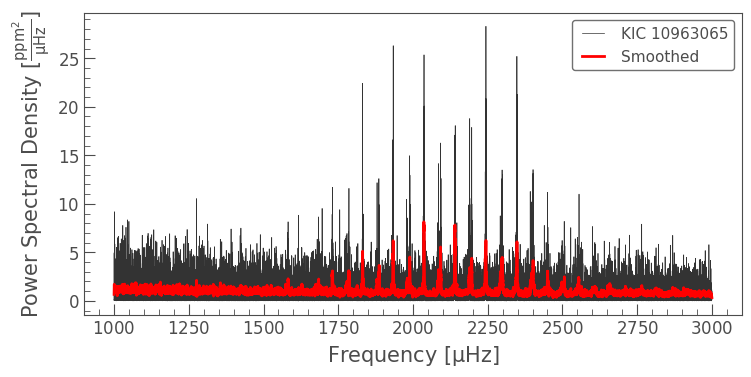

In [10]:
ax = pg.plot()
pg.smooth(method='boxkernel', filter_width=1.).plot(ax=ax, label='Smoothed', c='red', lw=2);

We could make a very rudimentary guess at $\nu_{\rm max}$ with that highest peak we see here. The `periodogram` object stores this info, lets have a look! 

In [11]:
pg.show_properties()

lightkurve.Periodogram properties:
      Attribute         Description     Units   
---------------------- -------------- ----------
                nterms              1           
              targetid       10963065           
          default_view      frequency           
                 label   KIC 10963065           
             ls_method           fast           
frequency_at_max_power      2244.0321        uHz
             max_power        28.2945 ppm2 / uHz
               nyquist      8496.4268        uHz
   period_at_max_power         0.0004    1 / uHz
             frequency array (47707,)        uHz
                period array (47707,)    1 / uHz
                 power array (47707,) ppm2 / uHz
                  meta <class 'dict'>           


The peak is located at $2244 \mu Hz$. 

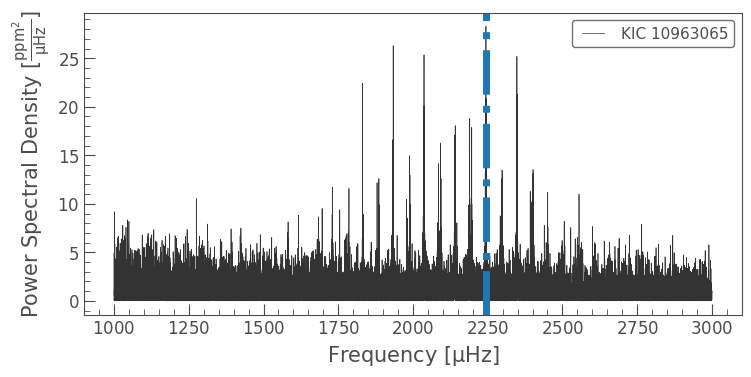

In [12]:
ax = pg.plot()
ax.axvline(pg.frequency_at_max_power.value, lw=5, ls='-.');1

Thats not quite in the center of the mod envelope. Let's try and do better with `lightkurve`'s asteroseismology tools.

## Using lightkurve's asteroseismology tools

Before we can use the seismology tools, we want to flatten out the background so we get a Signal-to-Noise (SNR) spectrum. This is to make sure that low-frequency noise doesn't mess up our estimation process. The flattening will never be as good as a proper fit to the granulation background, but `lightkurve` is first and foremost an investigative tool, so this method will do for now!

This operation returns a `SNRPeriodogram`. Its the same as a regular `LombScarglePeriodogram` in every way, except the power is now a unitless signal-to-noise ratio.

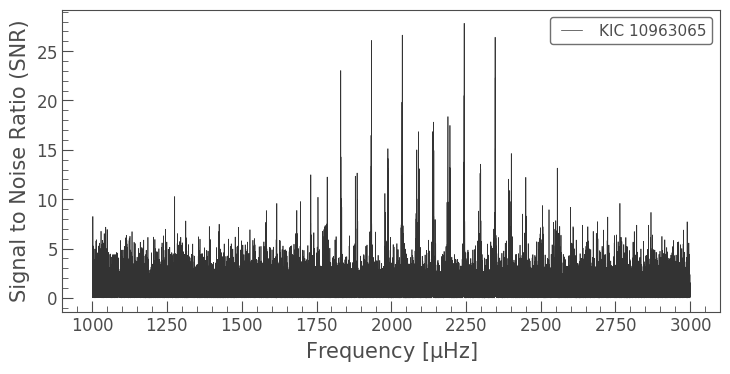

In [13]:
snr = pg.flatten()
snr.plot()

The seismology tools are all together in a seperate sub-module, called `Seismology`. Let's call it and get to work on our seismology estimates!

In [14]:
seis = snr.to_seismology()
seis

Seismology(ID: 10963065) - no values have been computed so far.

You can see that seismology is letting us know no values have been computed so far. As we estimate stellar parameters, seismology will fill up.

The periodogram object is stored as a property of seismology, so you can still call it like this:

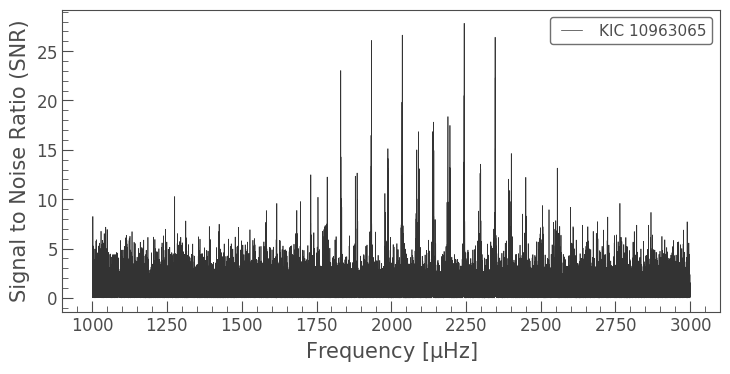

In [15]:
seis.periodogram.plot()

Alright, now let's get to business and try to estimate $\nu_{\rm max}$. The built-in method uses an Autocorrelation Function (following the techniques in Viani et al. 2019) to find where the power excess is highest in a shape approximately close to what we would expect for a solar-like oscillator's modes.

In [16]:
numax = seis.estimate_numax()
numax

numax: 2175.00 uHz (method: ACF2D)

Personally, I'm always a little uncomfortable with a line of code giving me a value without knowing whats going on under the hood. Fortunately, we have the option to check out some diagnostic plots with the `plot_numax_diagnostics()` function. Lets have a look.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x13c3b0ba8>,
      dtype=object)

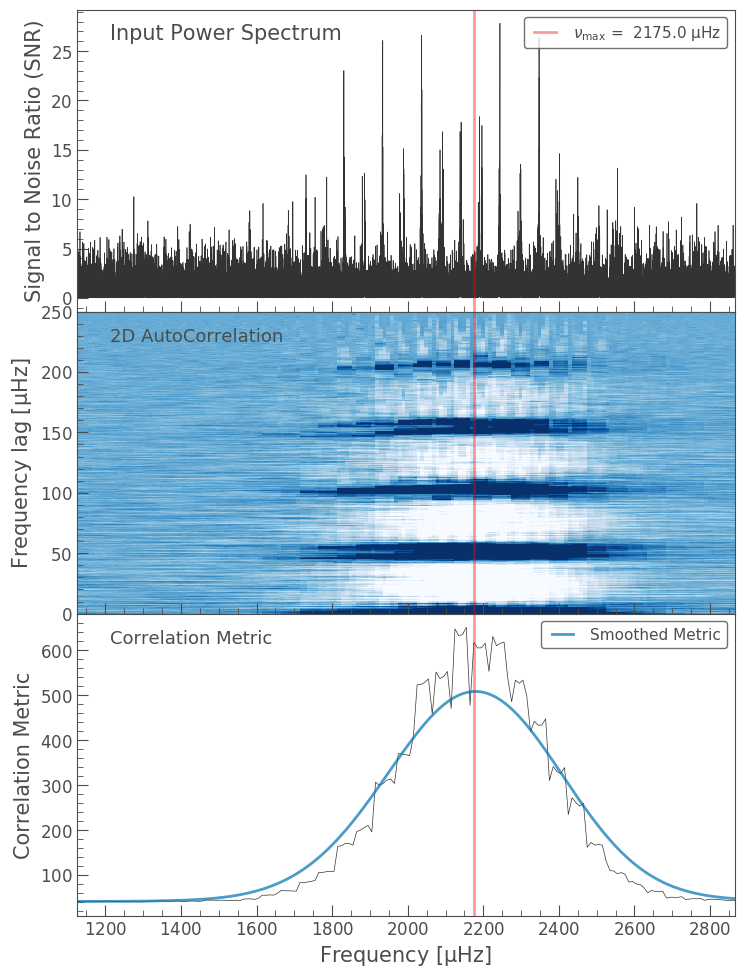

In [17]:
seis.diagnose_numax()

Looks like our 2D autocorrelation method is finding a value that doesn't look completely ridiculous. Neat! At time of writing, `lightkurve` does not return uncertainties on these values, preferring instead to be a quicklook tool. This may change in the future!

The next step is of course finding $\Delta\nu$. This also uses an autocorrelation method, but increases the width of the window so it covers the whole mode envelope.

Passing in the $\nu_{\rm max}$ autocorrelates a region approximately equivalent to the spread of the seismic mode envelope. Because this is where the p-modes reside, the resulting function should show neatly spaced peaks at a frequency lag equal to $\Delta\nu$. Seismology stores all its calculated values. You can pass a numax into this function, but ideally we'll want to have run `.estimate_numax()` first!

We estimate the $\Delta\nu$ first, and then have a look at the diagnostics.

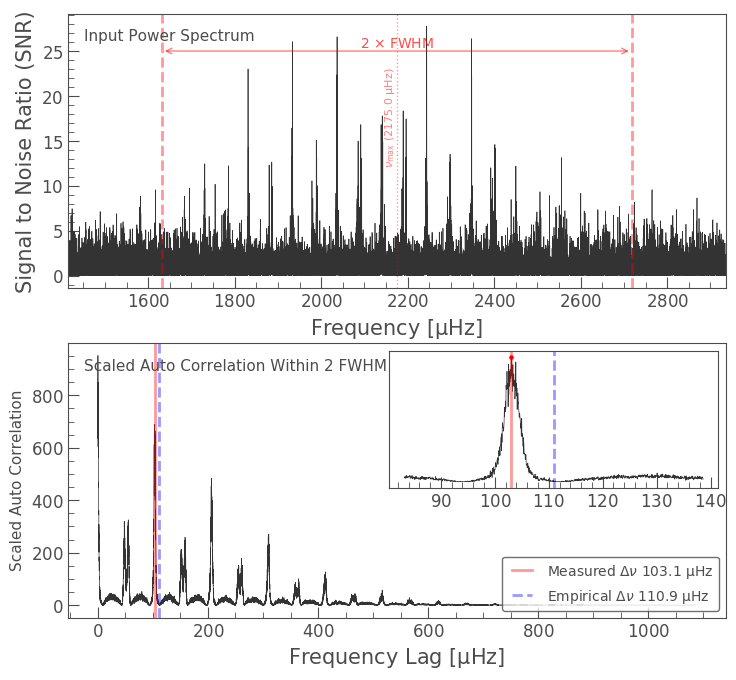

In [18]:
deltanu = seis.estimate_deltanu()
ax = seis.diagnose_deltanu()

That looks broadly sensible! This method will never get something as accurate as a dedicated mode fitting effort, but it functions as a good first-look tool.

The real hallmark of a good $\Delta\nu$ is that it produces a nice echelle diagram. All `periodogram` classes have access to the `plot_echelle()` function, which only requires a $\Delta\nu$. If we pass it a $\nu_{\rm max}$ too, it just shows the area around the seismic mode envelope we care about!

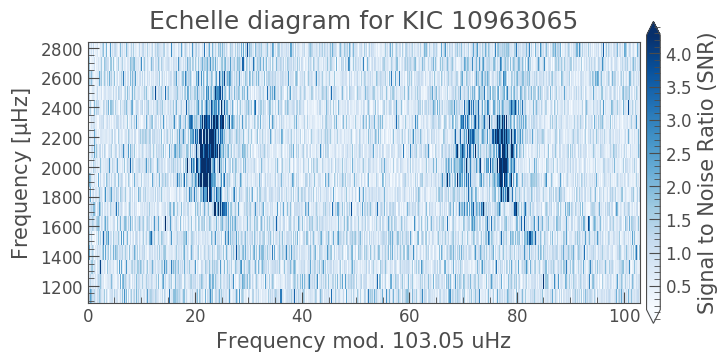

In [19]:
seis.plot_echelle()

If you (like me) prefer to smooth your echelle diagrams a little, we can do so using the `smooth_filter_width` kwarg, which calls `seismology.periodogram.smooth(filter_width=smooth_filter_width)` internally. We can also play around with the plotting keywords a little, to make it more visible.

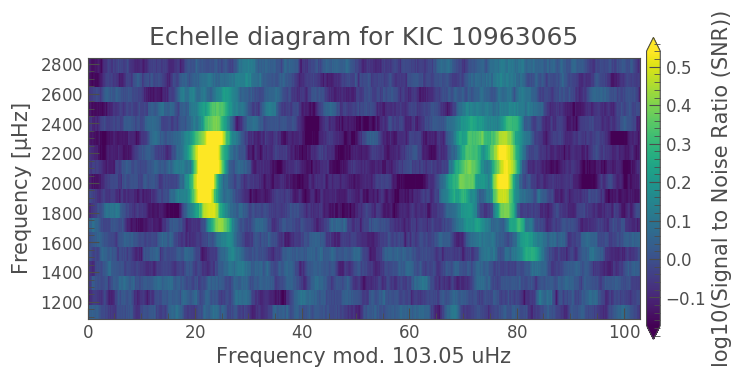

In [20]:
seis.plot_echelle(smooth_filter_width=3., scale='log', cmap='viridis')

Thanks to the high signal-to-noise of these data, you can see the radial, dipole, and quadrupole modes clearly in the spectrum, including slight curvature in the mode frequencies. Not bad for 10 minutes in an iPython notebook!

If we have a look at the Seismology module now, we'll notice it's holding on to our estimated $\nu_{\rm max}$ and $\Delta\nu$ values! We can recover them as attributes of seismology:

In [21]:
print(seis)
seis.deltanu

Seismology(ID: 10963065) - computed values:
 * numax: 2175.00 uHz (method: ACF2D)
 * deltanu: 103.05 uHz (method: ACF2D)


deltanu: 103.05 uHz (method: ACF2D)

Finally, let's try and find some stellar parameters using these data we've obtained.

## Using the seismic scaling relations with lightkurve

We've built the basic seismic scaling relations into `lightkurve` to make entry-level asteroseismology simpler. This comes with a few caveats of course--- it doesn't return uncertainties by default, and it is not equipped (yet) to deal with corrections to the scaling relations that are required to get accurate stellar parameters for more evolved stars.

Rudy is a main sequence star, so good enough for now! I know the temperature of this star to be $T_{\rm eff} = 6046\, K$. I had to look this up, unfortunately `lightkurve` can't do everything for us. The temperature and 'truth' values are the results from the Asteroseismic Modelling Portal (AMP) reported in [Mathur et al. 2012](https://arxiv.org/abs/1202.2844).

In [22]:
Teff = 6046
trueradius = 1.20
truemass = 1.03
truelogg = 4.29

In [23]:
mass = seis.estimate_mass(Teff)
mass

mass: 1.10 solMass (method: Uncorrected Scaling Relations)

We can do the same again for radius and surface gravity.

In [24]:
radius = seis.estimate_radius(Teff)
radius

radius: 1.24 solRad (method: Uncorrected Scaling Relations)

In [25]:
logg = seis.estimate_logg(Teff)
logg

logg: 4.30 dex (method: Uncorrected Scaling Relations)

The literature values for these are:

In [26]:
print('Radius : {} vs {:.2f} Rsol'.format(trueradius, radius.value))
print('Mass : {} vs {:.2f} Msol'.format(truemass, mass.value))
print('logg : {} vs {:.2f} dex'.format(truelogg, logg.value))

Radius : 1.2 vs 1.24 Rsol
Mass : 1.03 vs 1.10 Msol
logg : 4.29 vs 4.30 dex


That puts us pretty close!

I hope you enjoyed this little introduction to `lightkurve`'s suite of asteroseismology tools. We hope it functions as a good quick-look tool and as a useful hands-on introduction to the field of asteroseismology for new students and established academics alike!

In [27]:
seis

Seismology(ID: 10963065) - computed values:
 * numax: 2175.00 uHz (method: ACF2D)
 * deltanu: 103.05 uHz (method: ACF2D)
 * mass: 1.10 solMass (method: Uncorrected Scaling Relations)
 * radius: 1.24 solRad (method: Uncorrected Scaling Relations)
 * logg: 4.30 dex (method: Uncorrected Scaling Relations)